# Exercise
**Introduction to Game Screenshot Classification Exercise**

Welcome to the Game Screenshot Classification Exercise! In this exercise, we'll delve into the exciting world of deep learning and computer vision by tackling a real-world problem: classifying game screenshots into different game categories using machine learning techniques. This exercise is designed to provide us with insights into your technical capabilities when it comes to applying machine learning concepts to vision-based tasks.

**Background**

The gaming industry has grown exponentially over the years, and with it comes an incredible diversity of game genres. From action-packed shooters to immersive role-playing adventures, each game category offers a unique visual experience. As game enthusiasts, we often find ourselves intrigued by how different game types can be visually distinct. Our goal is to leverage the power of machine learning to automatically classify these screenshots based on their visual content.

**Objective**

Your task is to develop a machine learning model that can accurately classify game screenshots into predefined game categories. The provided dataset includes a variety of screenshots from different games, each labeled with the corresponding game category. By building this classification model, you'll demonstrate your ability to work with images, preprocess data, design and train neural networks, and evaluate the model's performance.

**Exercise Steps**

1. **Data Exploration**: Begin by familiarizing yourself with the dataset. Understand the structure of the data, the game categories, and the distribution of samples within each category.

2. **Data Preprocessing**: Data preparation is crucial for successful model training. You'll need to preprocess the images, resizing them to a consistent size, and normalizing the pixel values.

3. **Model Architecture**: Choose an appropriate deep learning architecture for image classification. Convolutional Neural Networks (CNNs) are commonly used for such tasks due to their ability to capture spatial hierarchies within images.

4. **Model Training**: Split the dataset into training, validation, and potentially testing sets. Train your chosen model architecture on the training data, using appropriate loss functions and optimization algorithms.

5. **Model Evaluation**: Evaluate the trained model's performance on the validation set. Metrics like accuracy, precision, recall, and F1-score can provide insights into how well the model generalizes to new data.

6. **Fine-Tuning and Hyperparameter Optimization** (Discussion): Experiment with different architectures, regularization techniques, and hyperparameters to achieve the best possible performance.

**Conclusion**

By completing this exercise, you'll demonstrate your ability to apply fundamental machine learning concepts to a real-world task involving image classification. Your thoughtful approach to data preprocessing, model selection, training, and evaluation will provide us with valuable insights into your technical proficiency and problem-solving skills.

Remember, while achieving high accuracy is important, equally important is your ability to reason about your model's behavior and make informed decisions throughout the process. Good luck, and have fun exploring the world of deep learning and game screenshots!

In [10]:
import time
import datetime
import json
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import asyncio
import aiohttp
import os
import nest_asyncio
from pathlib import Path
import hashlib
import langdetect
import plotly.express as px
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import requests

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# vision
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedGroupKFold
import tensorflow_hub as hub

# nlp
import transformers
from transformers import BertTokenizerFast, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

pd.options.plotting.backend = "plotly"

In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [12]:
df_path = "data/appstore_metadata_sampled.csv"
df = pd.read_csv(df_path, index_col=0)
df.loc[:, 'screenshots'] = df.screenshots.apply(lambda x: json.loads(x.replace('\'', '\"')) if type (x)!= float else [])


In [13]:
df.head()

appid                    publisher  \
5642   469369175  NaturalMotion Games Limited   
5584  1669871895              Ferenc Bodovics   
5546  1661647706        MIDNIGHT GAMES S.R.L.   
5580  1512032170       Digital Dream Labs LLC   
5796   879051761      Appollonia Blue Pty Ltd   

                                                 title  \
5642                                        CSR Racing   
5584                                 Gourilla Game Tag   
5546                     Kanjozokuレーサ Racing Car Games   
5580                                     OverDrive 2.6   
5796  Empire Runner: Champion of the X Blade Battalion   

                            subtitle  \
5642                             NaN   
5584  Run, Jump and Climb your hands   
5546  Highway Driving Simulator 2023   
5580                             NaN   
5796                             NaN   

                                            description category  \
5642  This is CSR Racing. The ultimate drag race in ...   Racing   
5584  Run, climb and jump. Run or get caught. Use yo...   Racing   
5546  Explore an amazing world of racing bay acquiri...   Racing   
5580  Digital Dream Labs is proud to present Overdri...   Racing   
5796  Presented by Appollonia Blue \n\nEmpire Runner...   Racing   

                                            screenshots  _row  
5642  [https://is1-ssl.mzstatic.com/image/thumb/Purp...   1.0  
5584  [https://is1-ssl.mzstatic.com/image/thumb/Purp...   1.0  
5546  [https://is1-ssl.mzstatic.com/image/thumb/Purp...   1.0  
5580  [https://is1-ssl.mzstatic.com/image/thumb/Purp...   1.0  
5796  [https://is1-ssl.mzstatic.com/image/thumb/Purp...   1.0

# Data visualization

**TODO:** \
Make some basic data visualization regarding the dataframe (include screenshots, and text columns)

738 rows in the DataFrame


In [14]:
len(df)

738

We observe missing values in the subtitle column


In [15]:
df.count()

appid          738
publisher      738
title          738
subtitle       619
description    738
category       738
screenshots    738
_row           738
dtype: int64

### Title

There are 738 unique game titles. Each line represents 1 game.


In [16]:
df.title.nunique()

738

### Publisher

There are 623 unique game titles. Few games are from the same publisher.  
We will not investigate further as the publisher shouldn't have an incidence on the screenshots classification task.

In [17]:
df.publisher.nunique()

623

### Category

There are 5 categories of game. Likely to be our target labels for the classification.


In [18]:
df.category.unique()

array(['Racing', 'Strategy', 'Casino', 'Sports', 'Puzzle'], dtype=object)

The dataset is quite imbalanced : more games in racing and casino categories than in the other ones.  
Before having any conclusions on the final data balance let's wait and observe the screenshots analysis.

In [19]:
df.category.hist(title='Number of games per categroy')

### _row

In [20]:
# _row column seems to be useless
df._row.nunique()

1

### Description

In [21]:
def word_frequency(category: str, feature: str, top_n: int=10, df: pd.DataFrame=df) -> None:
    # Displays word frequency wordcloud and histogram.
    text = " ".join(i.lower() for i in df[df.category==category][feature])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    top_words = {k: wordcloud.words_[k] for k in list(wordcloud.words_)[:10]}
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Most frequent words for category : {category}  in feature : {feature}', fontsize=16)
    ax1.imshow(wordcloud, interpolation='bilinear') 
    ax1.set_title("Wordcloud") 
    ax2.bar(top_words.keys(), top_words.values())
    ax2.set_title("Top 10 words") 
    plt.show()

It appears that specific words appear for each category.  
It will be useful if we decide to classify the screenshots based on to the description feature.

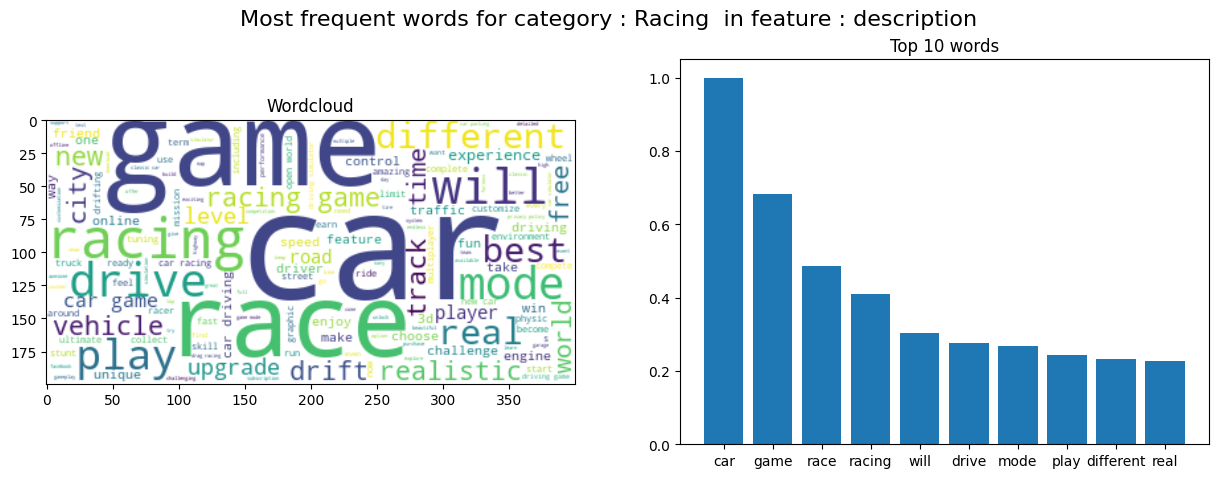

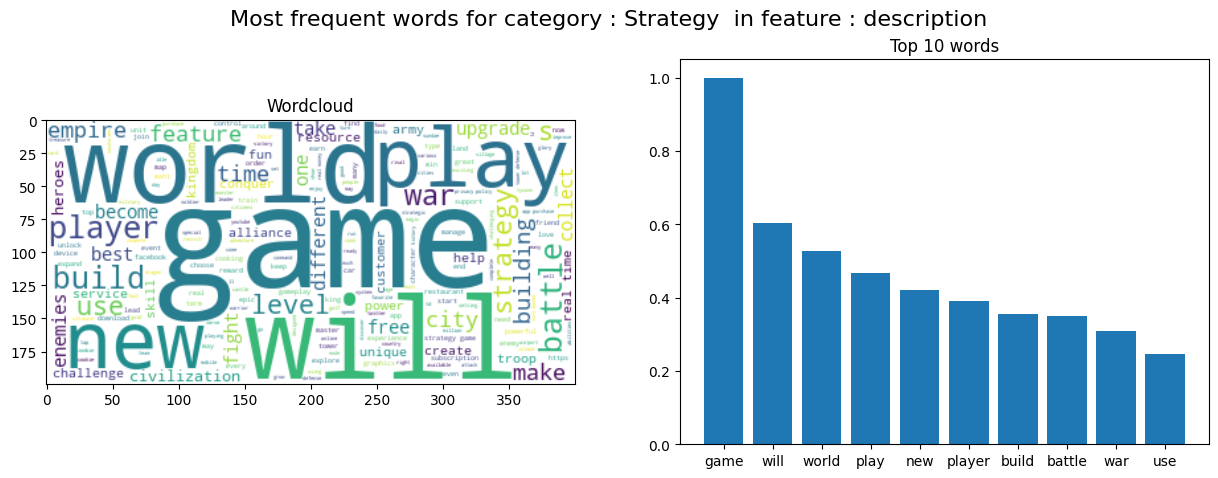

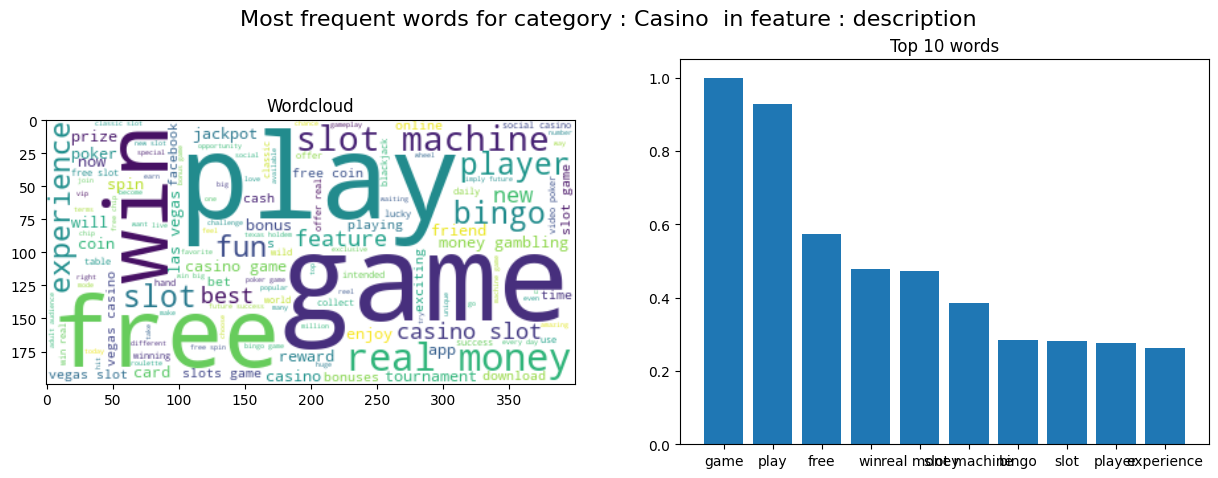

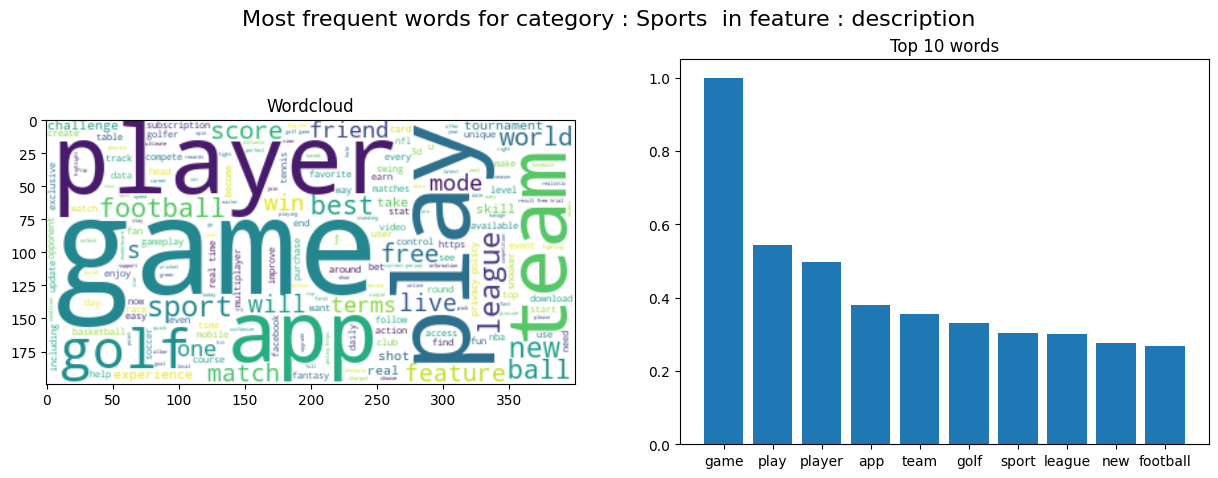

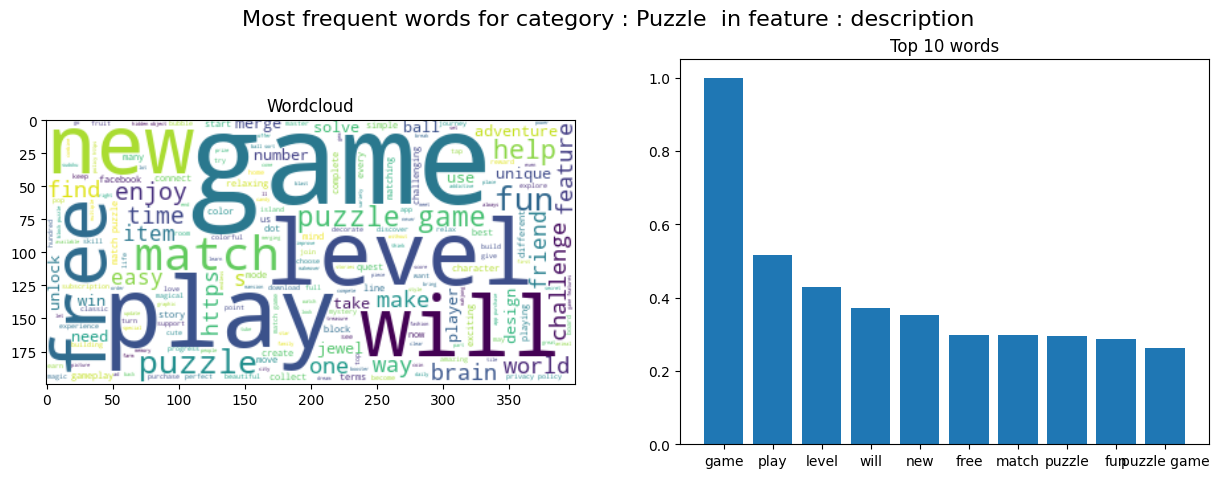

In [22]:
categories = df.category.unique()
for cat in categories:
    word_frequency(cat, 'description')

### Subtitle

Same conclusion as the 'description' column.  
NaN values need to be taken in consideration if we decide to use subtitles as a feature for the screenshots classifciation.

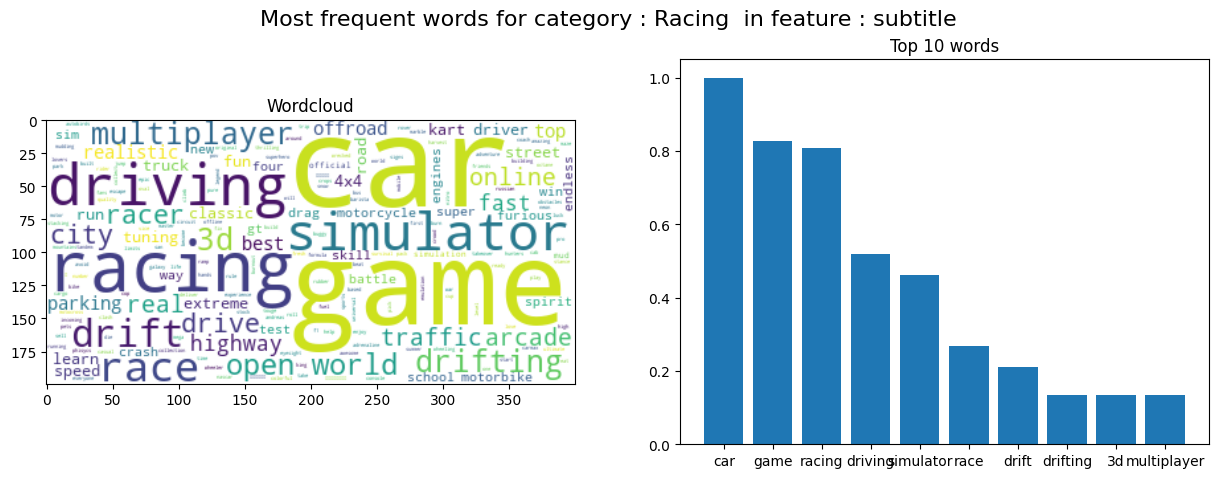

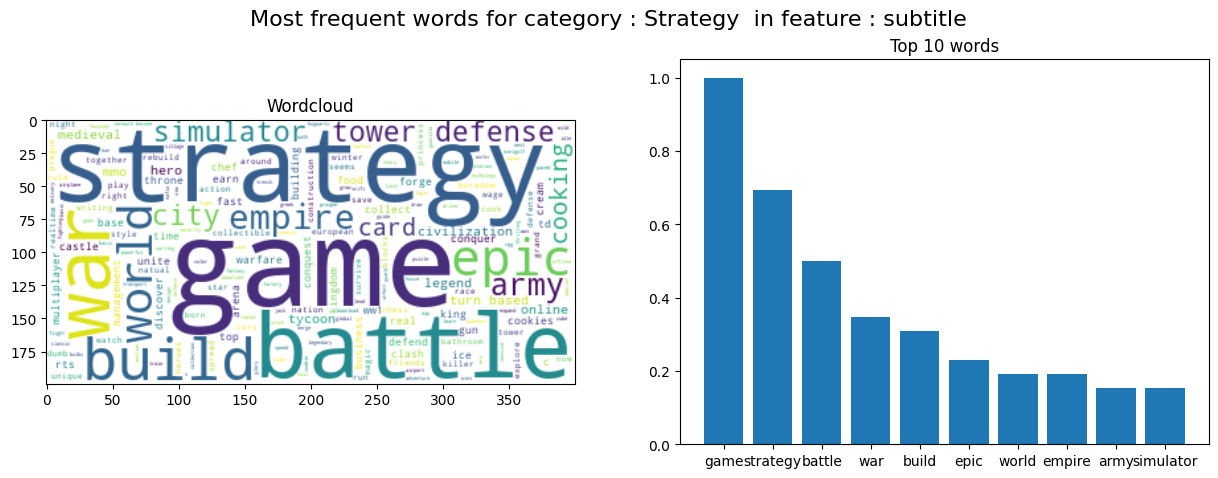

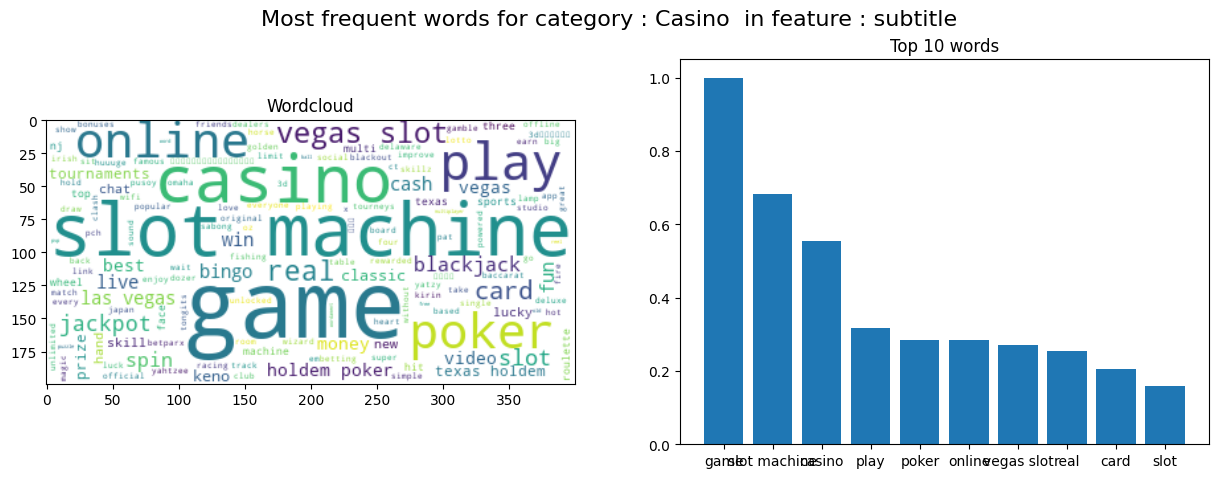

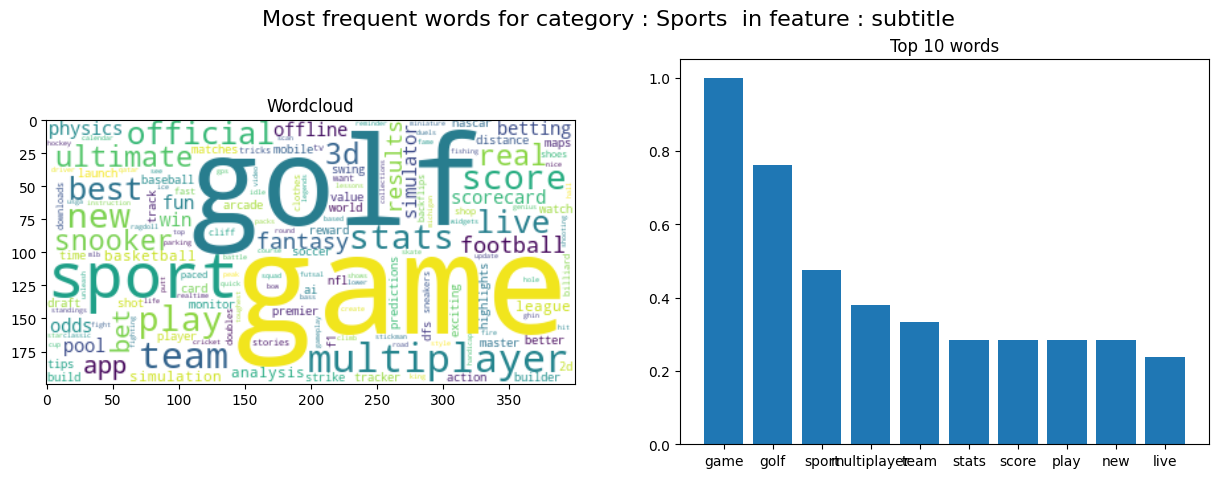

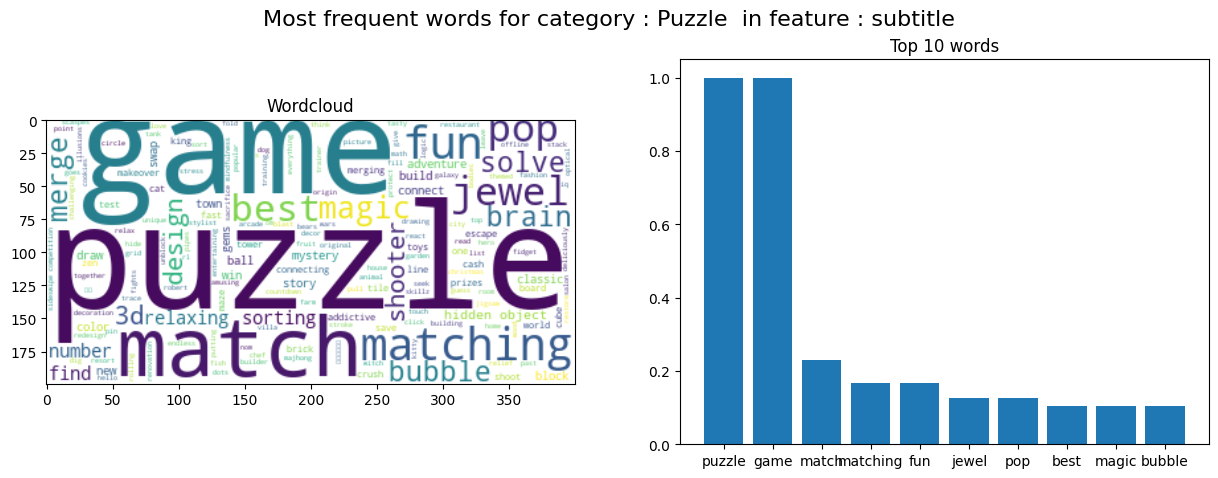

In [23]:
df_sub = df[df['subtitle'].notna()]
for cat in categories:
    word_frequency(cat, 'subtitle', df=df_sub)

### Screenshots

There are several screenshots per games

In [24]:
df['nb_screenshots'] = df.screenshots.str.len()
df['nb_screenshots'].describe()

count    738.000000
mean       6.043360
std        2.025821
min        0.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: nb_screenshots, dtype: float64

2 Games without any screenshot

In [25]:
df[df.nb_screenshots == 0]

appid                                publisher  \
3361  1089790084                     Commseed Corporation   
2759   882417244  Shanghai Zhenglang Technology Co., Ltd.   

                            title subtitle  \
3361  [GP]CRミリオンゴッドライジング(パチンコゲーム)      NaN   
2759         Slot Machines Casino      NaN   

                                            description category screenshots  \
3361  ■機種について\nグリパチにパチンコアプリの神降臨！\n株式会社メーシー（ユニバーサルエンタ...   Casino          []   
2759  A great vegas slot machines FREE game for you!...   Casino          []   

      _row  nb_screenshots  
3361   1.0               0  
2759   1.0               0

As expected in the category analysis, the dataset is quite imbalanced.  
Further smpling or data augmentation methods might be interesting to explore.

In [26]:
df_screenshots = df.groupby(['category'], as_index=False).sum()
df_screenshots.plot.bar(x='category', y='nb_screenshots', title='Number of screenshots per categroy')

Screenshot exemple

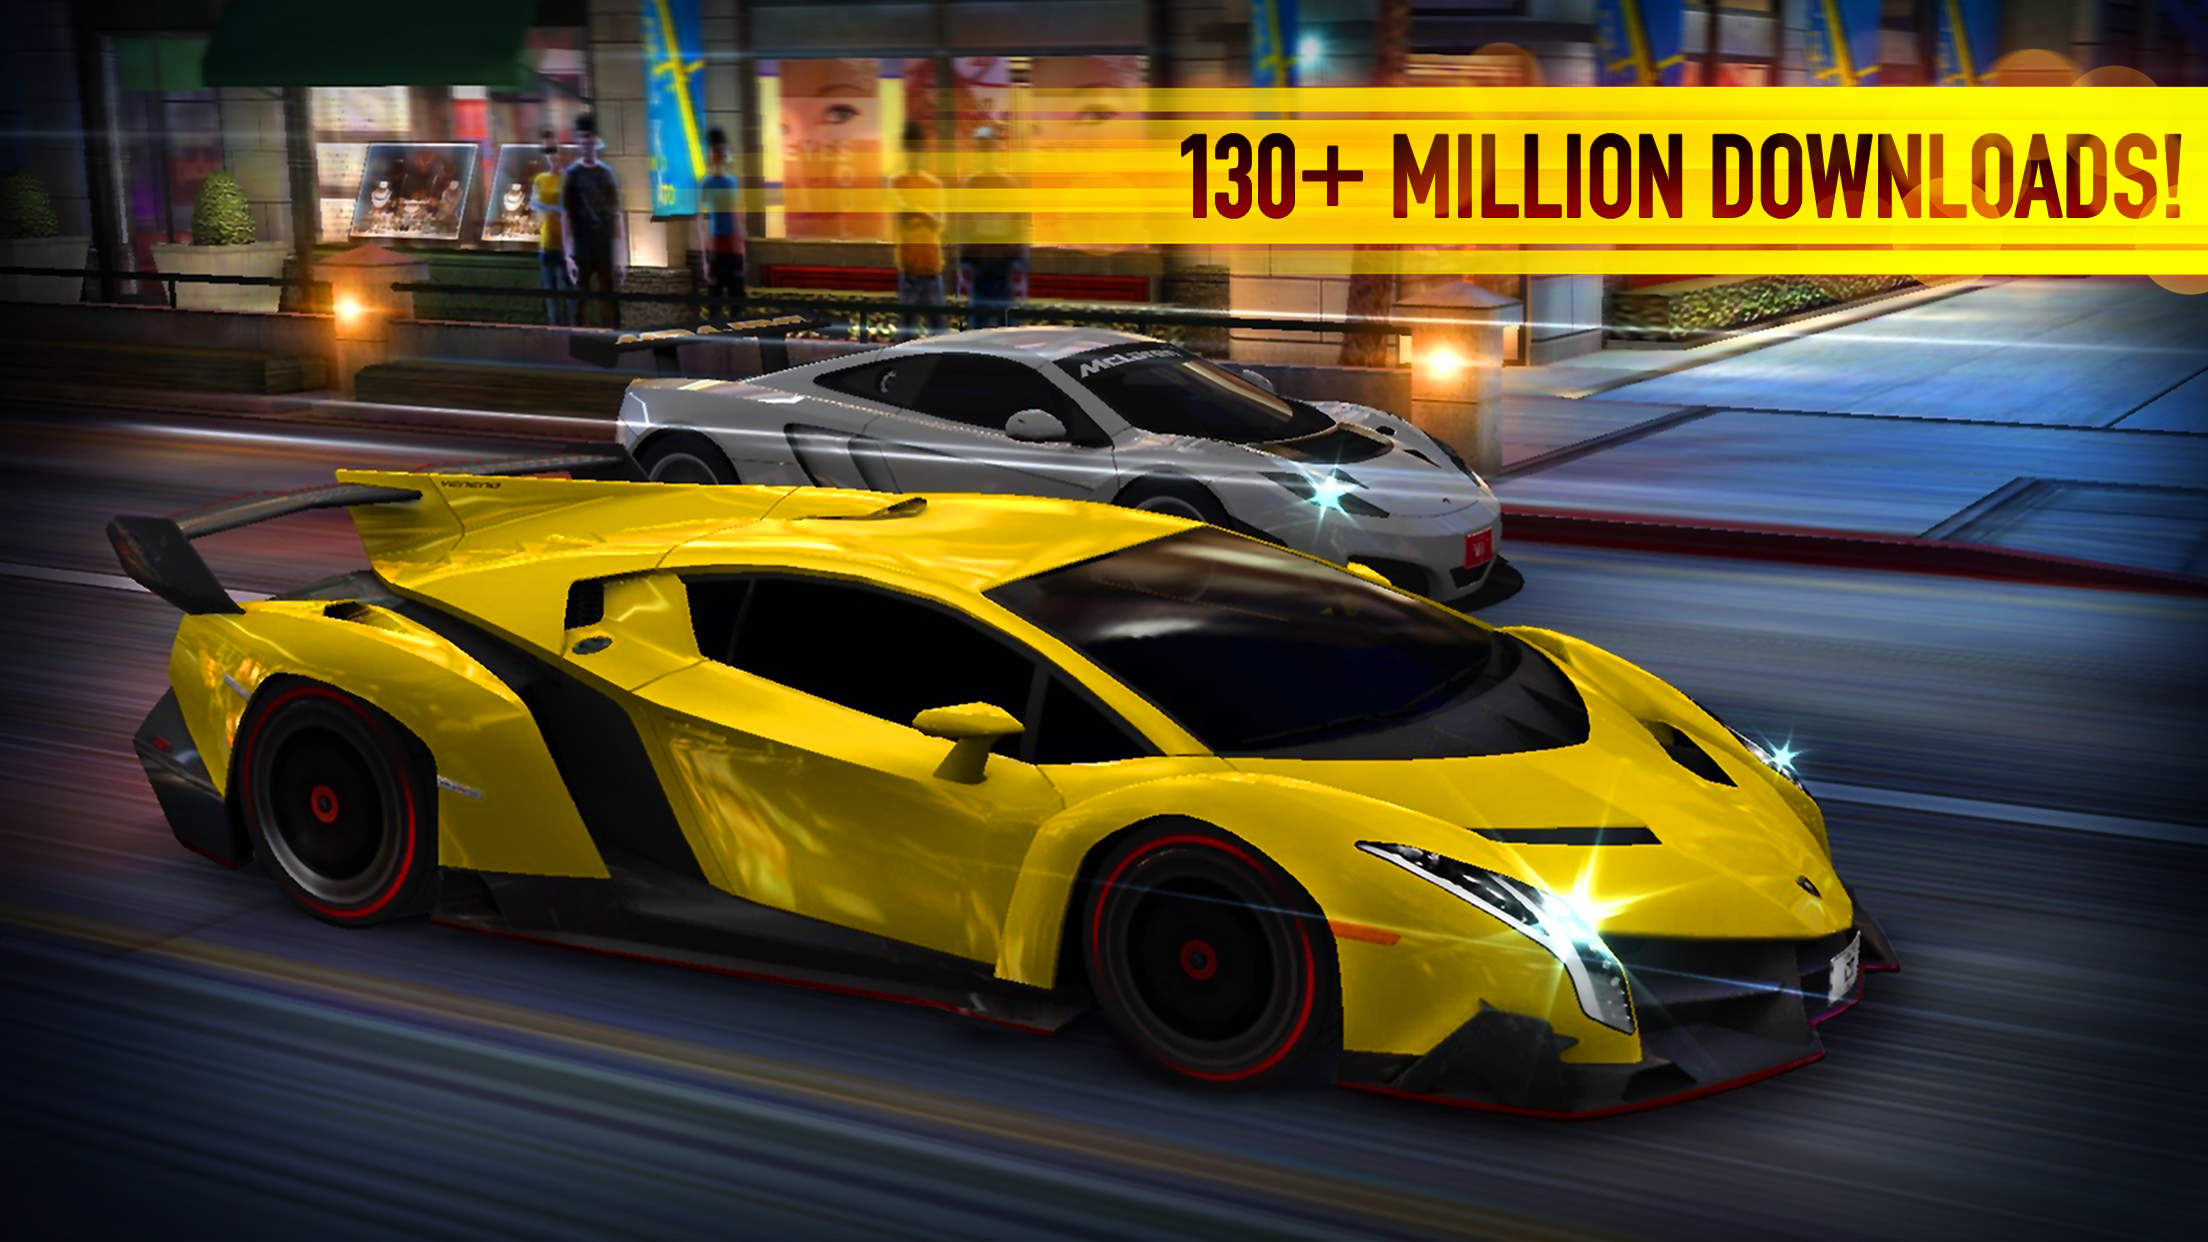

In [27]:
im = Image.open(requests.get(df.iloc[0,].screenshots[0], stream=True).raw)
im

# Vision

## Proprocessing

**TODO:** \
create `df_images`, a dataframe with columns: ['asset_url', 'label'] that will use us for training

In [28]:
# We remove games without screenshots
df_images = df[df.nb_screenshots != 0]
df_images = df_images.explode('screenshots')
df_images = df_images[['screenshots', 'category']]
df_images = df_images.rename(columns={"screenshots": "asset_url", "category": "label"})
df_images

asset_url   label
5642  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Racing
5642  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Racing
5642  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Racing
5584  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Racing
5584  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Racing
...                                                 ...     ...
4784  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Puzzle
4784  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Puzzle
4784  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Puzzle
4784  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Puzzle
4784  https://is1-ssl.mzstatic.com/image/thumb/Purpl...  Puzzle

[4460 rows x 2 columns]

## Data Fetching

In [29]:
def allow_ssl_connection():
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

allow_ssl_connection()


In [30]:
nest_asyncio.apply()
image_assets_path = "downloads/images"
Path(f'{image_assets_path}/datasets').mkdir(parents=True, exist_ok=True)
async def download_image(session, url, save_path, verbose=True):
    try:
        if Path(save_path).exists(): 
            if verbose: 
                print(f"Downloaded {url} to {save_path}")
            return 
        async with session.get(url) as response:
            if response.status == 200:
                content = await response.read()
                with open(save_path, 'wb') as f:
                    f.write(content)
                    if verbose:
                        print(f"Downloaded {url} to {save_path}")
                        return
            else:
                if verbose:
                    print(f"Failed to download {url} (status code: {response.status})")
                    return
    except Exception as e:
        if verbose:
            print(f"An error occurred while downloading {url}: {e}")
            return

async def main(urls, image_assets_path):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in urls:
            image_name = url.split('/')[-1]
            suffix = Path(url).suffix
            hash_code = f"{hashlib.sha256(url.encode()).hexdigest()}{suffix}"
            save_path = os.path.join(image_assets_path, 'datasets', hash_code)
            task = asyncio.ensure_future(download_image(session, url, save_path))
            tasks.append(task)
        responses = [await f
                 for f in tqdm(asyncio.as_completed(tasks), total=len(tasks))]

def get_missing_files(urls, assets_dir):
    def get_local_file_name(data):
        url = str(data)

        suffix = Path(url).suffix
        hash_code = f"{hashlib.sha256(url.encode()).hexdigest()}{suffix}"
        return hash_code

    fnames = []
    for url in urls:
        fnames.append(get_local_file_name(url))
    fnames = pd.Series(fnames, index=urls, name='fname')

    Path(assets_dir).mkdir(exist_ok=True, parents=True)
    p = Path(assets_dir).glob('**/*')
    files_in_dir = [x.name for x in p]
    missing_files_ = fnames[~fnames.isin(files_in_dir)].index.values
    existing_files_ = fnames[fnames.isin(files_in_dir)].index.values
    return existing_files_, missing_files_

**TODO:** \
Create a script to download all assets locally, 
- use asyncio
- Monitor downlodaded assets with:
    - `existing_files` - list of all existing files
    - `missing_files` - list of all missing files

In [31]:
# urls = df_images.asset_url.to_list()
# asyncio.run(main(urls, image_assets_path))

In [32]:
existing_files, missing_files = get_missing_files(df_images.asset_url, f"{image_assets_path}/datasets")
print("existing_files:", len(existing_files))
print("missing_files:" ,len(missing_files))


existing_files: 4460
missing_files: 0


## Datasets

**TODO:**
1. Create (train, test, val) datasets with augmentation and preprocess pipelines
    1. Preprocess: 
        - Resize
    2. Augmentation: 
        - contrast

**Discussion:** 
- When would we use augmentation?
- What other augmentations would you suggest?

In [33]:
# Models list and input cnfigurations
model_handle_map = {
    "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
    "inception": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
}

model_image_size_map = {
    "efficientnetv2-s": 384,
    "inception": 224,
}

MODEL_LABELS = sorted(df_images.label.unique().tolist())


In [25]:
# Split dataset into train, validation and test dfs
def create_dfs(df_images):
    # TODO: Create train test validation dfs (80, 10, 10)
    train_df, _val_test_df = train_test_split(df_images, test_size=0.2, stratify=df_images.label)
    val_df, test_df = train_test_split(_val_test_df, test_size=0.5, stratify=_val_test_df.label)
    print(np.shape(train_df), np.shape(test_df), np.shape(val_df))
    return train_df, val_df, test_df


def create_datasets(model_name, df_images, image_size, model_labels):
    def augment(img, augment_config: dict = None):
        # Make a new seed.
        seed = rng.make_seeds(2)[0]
        if augment_config.get('resize'):
            # TODO: add resize
            img = tf.image.resize_with_pad(img, image_size[0], image_size[1])
            pass
        if augment_config.get('contrast'):
            # TODO: Add contrast
            img = tf.image.adjust_contrast(img, 2.)
        if augment_config.get('flip'):
            img = tf.image.stateless_random_flip_left_right(img, seed=seed)
        return img


    def dataframe_to_dataset(df, shuffle=True, augment_config: dict = None):
        ds = tf.data.Dataset.from_tensor_slices((df.asset_url.values, le.transform(df.label)))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(df))
        ds = ds.map(lambda x, y: (read_image_from_url(x), y))
        if augment_config is not None:
            ds = ds.map(lambda x, y: (augment(x, augment_config=augment_config), y))
        ds = ds.map(lambda x, y: (normalization_layer(x), y))
        return ds
    
    def get(data):
        try:
            url = str(data.numpy().decode("utf-8"))
        except:
            url = data
        suffix = Path(url).suffix
        hash_code = f"{hashlib.sha256(url.encode()).hexdigest()}{suffix}"
        fpath = tf.keras.utils.get_file(hash_code, url, cache_dir=image_assets_path)
        res = tf.keras.utils.load_img(fpath, target_size=image_size)
        return res

    def read_image_from_url(data):
        return tf.py_function(get, [data], tf.uint8)
    
    train_df, val_df, test_df = create_dfs(df_images)
    le = LabelEncoder().fit(model_labels)
    pixels = model_image_size_map.get(model_name, 224)
    
    
    image_urls = df_images.asset_url
    dataset = tf.data.Dataset.from_tensor_slices(image_urls)
    
    # make sure all assets are fetched
    dataset_images = dataset.map(lambda x: read_image_from_url(x))

    rng = tf.random.Generator.from_seed(33, alg='philox')

    print(le.classes_)
    class_weights = class_weight.compute_class_weight('balanced', classes=le.classes_,
                                                      y=train_df.label.values)
    class_weights = dict(enumerate(class_weights))

    normalization_layer = tf.keras.layers.Rescaling(1. / 255)

    augment_config=None
    if augment_config is None:
        # apply all augmentations
        augment_config = dict(
            resize=True,
            contrast=True,
            flip=True,
        )
    train_ds = dataframe_to_dataset(train_df, augment_config=augment_config)
    val_ds = dataframe_to_dataset(val_df, augment_config=augment_config)
    test_ds = dataframe_to_dataset(test_df, augment_config=None, shuffle=False)
    return train_ds, val_ds, test_ds, class_weights


## Model Training

**TODO:**
1. Train the models
    - How would you use all app's images results for classification (Discussion)
2. Use callbacks for: 
    (They don't have to be triggered during train)
    - early stopping
    - checkpoints
    - tensorboard for logging
3. Save the model


In [26]:
def arch1(model_name, retrain_model, num_classes, model_handle_map, model_image_size_map):
    model_handle = model_handle_map.get(model_name)
    image_size = (model_image_size_map[model_name], )*2

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
        hub.KerasLayer(model_handle, trainable=retrain_model),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return (f"{model_name}-arch1", (model, image_size))

def arch2(model_name, retrain_model, num_classes, model_handle_map, model_image_size_map):
    model_handle = model_handle_map.get(model_name)
    image_size = (model_image_size_map[model_name], )*2
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
        hub.KerasLayer(model_handle, trainable=retrain_model),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return (f"{model_name}-arch2", (model, image_size))



In [27]:
# Create models variations for optimization
retrain_model = False
num_classes = df_images.label.nunique()
model_names = list(model_handle_map.keys())


arch_funcs = [arch1, arch2]
models_permutations = dict()
for model_name in tqdm(model_names):
    for arch_func in tqdm(arch_funcs):
        name, (model, image_size) = arch_func(model_name, retrain_model, num_classes, model_handle_map, model_image_size_map)
        models_permutations[name] = (model, image_size)

# TODO: Finetune all models:        
models_permutations

  0%|          | 0/2 [00:00<?, ?it/s]

2023-10-24 05:07:38.712768: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-10-24 05:07:38.712801: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-24 05:07:38.712812: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-24 05:07:38.712921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 05:07:38.712942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|██████████| 2/2 [00:15<00:00,  7.86s/it]


{'efficientnetv2-s-arch1': (<keras.src.engine.sequential.Sequential at 0x2ff04e370>,
  (384, 384)),
 'efficientnetv2-s-arch2': (<keras.src.engine.sequential.Sequential at 0x2bee8abe0>,
  (384, 384)),
 'inception-arch1': (<keras.src.engine.sequential.Sequential at 0x330e79460>,
  (224, 224)),
 'inception-arch2': (<keras.src.engine.sequential.Sequential at 0x34c2121c0>,
  (224, 224))}

In [28]:
def train(
    model_name, model, image_size, df_images,
    epochs = 10,
    batch_size = 32,
    model_labels = None,
    models_dir_output_path='./tf/models',
    logs_folder_output_path = "./tf/logs/fit",
    models_stats_output_path = "./tf/stats"
):
    Path(models_dir_output_path).mkdir(exist_ok=True, parents=True)
    Path(logs_folder_output_path).mkdir(exist_ok=True, parents=True)
    
    train_ds, val_ds, test_ds, class_weights = create_datasets(
        model_name=model_name, 
        df_images=df_images, 
        image_size=image_size, 
        model_labels=model_labels
    )
    
    # prefetch for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE).cache()
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE).cache()
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
    model.build((None,) + image_size + (3,))
    print(model.summary())

    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=METRICS)

    log_dir =  f"{logs_folder_output_path}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # TODO: add tfboards logs
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, update_freq=1) 
    fname = f"{models_dir_output_path}/" + "weights--train-loss{loss:.2f}-acc{accuracy:.2f}--val-loss{val_loss:.2f}-acc{val_accuracy:.2f}.h5 "
    
    # TODO: add checkpoint
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(fname, monitor="val_loss", verbose=1, save_weights_only=True, save_best_only=True)
    # TODO: add early stopping
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3)
    
    callbacks = [tensorboard_callback, early_stopping_callback, checkpoint_callback]

    history = model.fit(
        train_ds.batch(batch_size),
        validation_data=val_ds.batch(batch_size),
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights
    )
    # TODO: Save model stats for easy retrieval of best model
    # access latest checkpoint
    latest = tf.train.latest_checkpoint(models_dir_output_path)

    # Loads the weights
    model.load_weights(latest)

    # model evaluation
    loss, accuracy = model.evaluate(test_ds.batch(batch_size), verbose=2)

    # saving model
    tf.keras.saving.save_model(model, f"{models_stats_output_path}/" + f"model--test-loss{loss:.2f}-acc{accuracy:.2f}")

    # saving dataset
    tf.data.Dataset.save(test_ds, f"{models_stats_output_path}/" + f"model--test-loss{loss:.2f}-acc{accuracy:.2f}/dataset")

    return model, history, test_ds

In [30]:
models = []
train_results = {}
test_ds_path = './tf/dataset/test'
for name, (model, image_size) in models_permutations.items():
    model, history, test_ds = train(
        model_name=model_name,
        model=model,
        image_size=image_size,
        df_images = df_images,
        model_labels=MODEL_LABELS
    )
    train_results[model_name] = model, history, test_ds
    models.append(train_results[model_name])



(3568, 2) (446, 2) (446, 2)
['Casino' 'Puzzle' 'Racing' 'Sports' 'Strategy']
Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                      

2023-10-24 05:07:54.795552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - ETA: 0s - loss: 1.1925 - accuracy: 0.5961
Epoch 1: val_accuracy improved from -inf to 0.57848, saving model to ./tf/models/weights--train-loss1.19-acc0.60--val-loss1.15-acc0.58.h5 
112/112 [==============================] - 425s 4s/step - loss: 1.1925 - accuracy: 0.5961 - val_loss: 1.1518 - val_accuracy: 0.5785
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.6855
Epoch 2: val_accuracy improved from 0.57848 to 0.61435, saving model to ./tf/models/weights--train-loss0.96-acc0.69--val-loss1.04-acc0.61.h5 
112/112 [==============================] - 35s 308ms/step - loss: 0.9599 - accuracy: 0.6855 - val_loss: 1.0430 - val_accuracy: 0.6143
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.9222 - accuracy: 0.7108
Epoch 3: val_accuracy did not improve from 0.61435
112/112 [==============================] - 35s 309ms/step - loss: 0.9222 - accuracy: 0.7108 - val_loss: 1.2702 - val_accuracy

INFO:tensorflow:Assets written to: ./tf/stats/model--test-loss1.24-acc0.65/assets


(3568, 2) (446, 2) (446, 2)
['Casino' 'Puzzle' 'Racing' 'Sports' 'Strategy']
Num GPUs Available:  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                8224      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                    

INFO:tensorflow:Assets written to: ./tf/stats/model--test-loss0.72-acc0.76/assets


(3568, 2) (446, 2) (446, 2)
['Casino' 'Puzzle' 'Racing' 'Sports' 'Strategy']
Num GPUs Available:  1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dropout_4 (Dropout)         (None, 1536)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                    

INFO:tensorflow:Assets written to: ./tf/stats/model--test-loss1.73-acc0.62/assets


(3568, 2) (446, 2) (446, 2)
['Casino' 'Puzzle' 'Racing' 'Sports' 'Strategy']
Num GPUs Available:  1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dropout_6 (Dropout)         (None, 1536)              0         
                                                                 
 dense_13 (Dense)            (None, 256)               393472    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                8224      
                                                                 
 dense_15 (Dense)            (None, 5)                 165       
                    

INFO:tensorflow:Assets written to: ./tf/stats/model--test-loss1.49-acc0.58/assets


## Prediction
**TODO:** \
Create a flask app that uses the model to predict the test data:
1. Load best model
2. Predict the test data


In [54]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

# TODO: read models output dir and retrieve the "best" model
def get_best_model(models_stats_output_path="./tf/stats"):
    subfolders = [f.path for f in os.scandir(models_stats_output_path) if f.is_dir()]
    top_score = 0
    top_idx = 0
    for idx, fold in enumerate(subfolders):
        model_score = float(fold[-4:])
        if model_score > top_score:
            top_score = model_score
            top_idx = idx
    model = tf.keras.models.load_model(f"{subfolders[top_idx]}")
    dataset = tf.data.Dataset.load(f"{subfolders[top_idx]}/dataset")
    return model, dataset

# TODO: Complete this
def predict(model, test_ds):
    x = np.array([x for x, y in test_ds])
    preds_df = model.predict(x)
    preds_df = np.array(tf.argmax(preds_df, 1))
    preds_df = [MODEL_LABELS[i] for i in preds_df]
    return preds_df


best_model, test_ds = get_best_model()
preds_df = predict(best_model, test_ds)
y_true = np.array([y for x, y in test_ds])
y_true = [MODEL_LABELS[i] for i in y_true]

print(multilabel_confusion_matrix(y_true, preds_df))
accuracy_score(y_true, preds_df)

14/14 [==============================] - 75s 3s/step
[[[335   6]
  [ 30  75]]

 [[304  59]
  [ 14  69]]

 [[337   6]
  [ 22  81]]

 [[349  14]
  [ 16  67]]

 [[354  20]
  [ 23  49]]]


0.7645739910313901

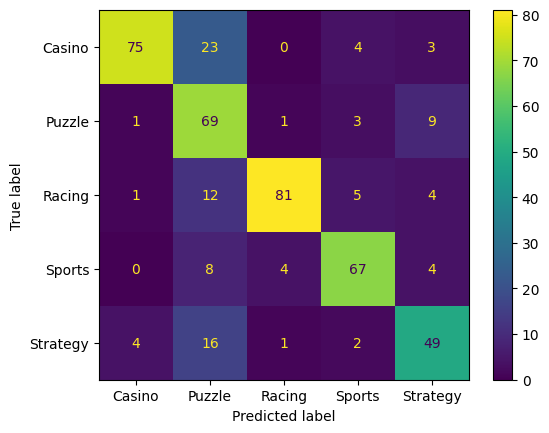

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, preds_df, labels=MODEL_LABELS)
disp = ConfusionMatrixDisplay(cm, display_labels=MODEL_LABELS)
disp.plot()

### Flask application

In [57]:
from flask import Flask

app = Flask(__name__)

@app.route('/',methods=['GET'])
def predict_test_ds():
    print('Prediction job started')
    best_model, test_ds = get_best_model()
    preds_df = predict(best_model, test_ds)
    return preds_df

if __name__ == "__main__":
    app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


14/14 [==============================] - 77s 4s/step


127.0.0.1 - - [24/Oct/2023 06:57:12] "GET / HTTP/1.1" 200 -


## Model Evaluation (discussion)
1. Use the multiple screenshots to predict app category
2. Continious learning and label management


## Finetuning and Optimization (discussion)